In [67]:
import time
# Obróbka danych
import pandas as pd
import numpy as np

# Wizualizacja 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mgno 

# Przygotowanie danych 
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials
from sklearn.model_selection import cross_validate,train_test_split,cross_val_score,KFold 
from sklearn.feature_selection import SelectPercentile, chi2
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer,make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline,FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, Normalizer, OrdinalEncoder, OneHotEncoder
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer,precision_score,recall_score,f1_score,classification_report

# Modele
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb

#Ziarno losowe
random_state=123
np.random.seed(42)

#Tworzenie logów
import logging

# Wyświetlanie notebooka
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Wizualizacje wykresów
fontdict = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }
from warnings import filterwarnings
filterwarnings('ignore')

In [68]:
def log(path, file):
    """[Create a log file to record the experiment's logs]
    
    Arguments:
        path {string} -- path to the directory
        file {string} -- file name
    
    Returns:
        [func] -- [logger that record logs]
    """

    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    handler = logging.FileHandler(log_file)

    handler.setLevel(logging.INFO)
    
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    logger.addHandler(handler)

    return logger

In [69]:
df = pd.read_csv("./water_potability.csv")
df.sample(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2947,NaN,183.521107,20461.252710,7.333212,333.119476,356.369022,20.179029,67.019903,4.886634,0
2782,6.643159,188.913541,32873.820022,6.791509,333.848842,336.561501,14.706810,67.844849,4.562198,1
1644,7.846058,224.058877,23264.109968,5.922367,300.402620,387.971336,13.406737,43.075186,2.487969,0
70,7.160467,183.089310,6743.346066,3.803036,277.599099,428.036344,9.799625,90.035374,3.884891,0
2045,6.615350,179.240661,26392.863612,9.309160,NaN,496.363562,12.786595,78.262369,4.453443,1
263,13.175402,47.432000,19237.949676,8.907020,375.147315,500.245952,12.083896,NaN,4.106924,1
1042,5.499489,230.308775,13902.968646,9.619575,352.084333,442.167006,14.740787,NaN,5.846827,0
2263,11.235426,178.596496,33773.107061,9.063042,327.650960,425.868039,17.986255,58.986652,5.147055,0
450,NaN,139.331152,2912.211247,10.338234,343.318021,532.885196,11.078341,42.172824,4.093098,0
1832,NaN,233.846621,32496.640216,6.637384,347.986448,424.649773,13.028000,55.983973,4.296189,0


The dataset consists of 3276 observations and is described by 10 features. All columns have continuous numeric values.

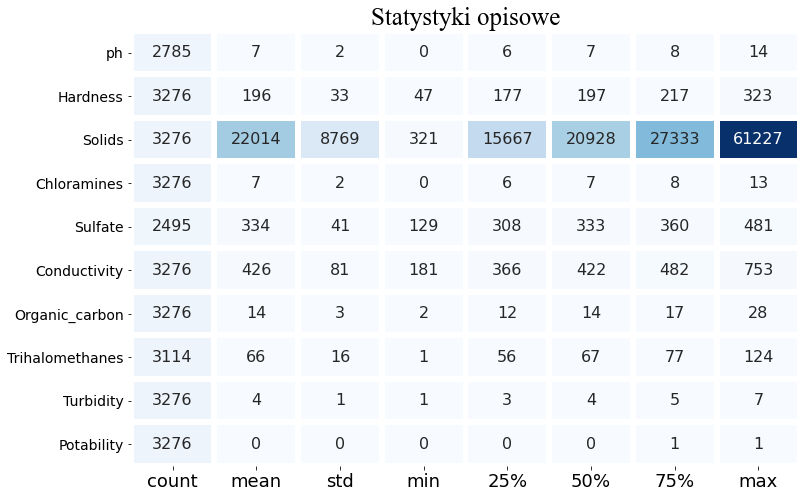

In [70]:
desc = df.describe().T
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(desc,annot=True,cmap = "Blues", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})
plt.xticks(size = 18)
plt.yticks(size = 14, rotation = 0)
plt.title("Statystyki opisowe", fontdict=fontdict)
plt.show()

From the descriptive statistics visualization we can see that the mean is slightly higher than the median for the columns: Solids, Conductivity. It can be a proof of right skewness of distribution of these two variables. 

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


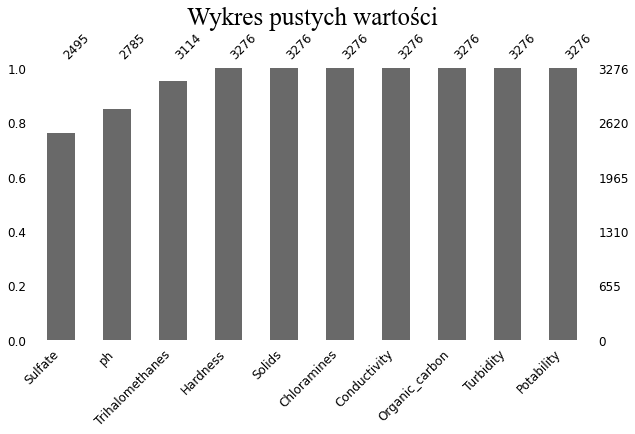

In [72]:
mgno.bar(df, figsize=(10,5), fontsize=12,sort="ascending");
plt.title('Wykres pustych wartości',fontdict=fontdict)
plt.show()
#print(df.isnull().sum())

Data have NaN values in the pH, Sulfate, Trihalomethanes columns. 

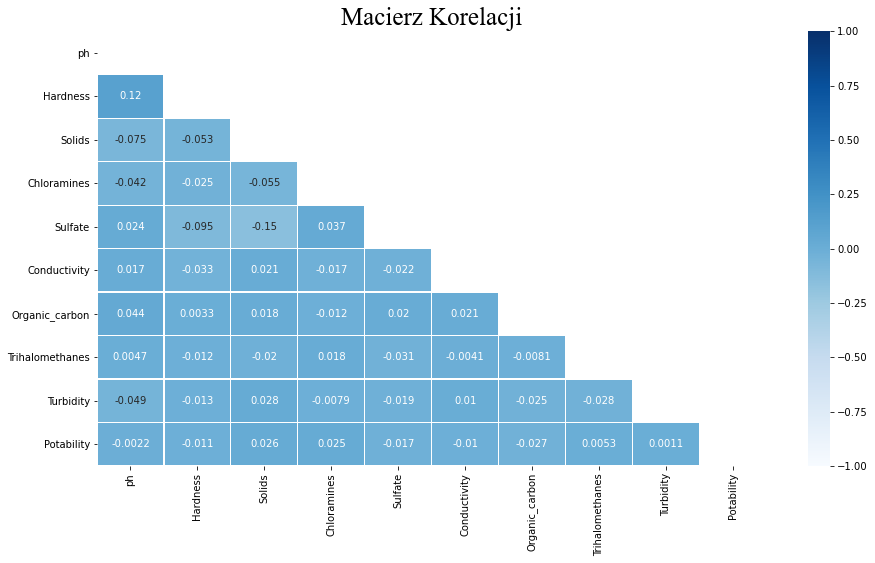

In [73]:
plt.figure(figsize=(15,8))
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0,cbar_kws={'alpha':0.1})
plt.title('Macierz Korelacji',fontdict=fontdict)
plt.show()

In correlation matrix we used Spearman rank correlation, because there is no assumption about variables distribution, target variable is categorical variable (yes / no), but also dichotomous, so in ranking it doesn't really matter if it is categorical (as long as we want to detect level of correlation and dependencies, not direction of correlation), it is value based ranking, so this method is robust to outliers. In the visualization we can see that no variable is highly correlated with each other. So all variables are neutrally correlated.

In [74]:
#sns.pairplot(data=df,hue='Potability',plot_kws={'alpha':0.3}),

With this visualization, we can see that our data definitely has no correlation, as we can see that they are "point clouds".

In [75]:
cols = df.columns[:-1]
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

ph = 0.025630447632210302
Hardness = -0.03934170477672744
Solids = 0.6216344855169127
Chloramines = -0.012098440124382135
Sulfate = -0.03594662160706183
Conductivity = 0.2644902239264119
Organic_carbon = 0.02553258209024246
Trihalomethanes = -0.08303067407901549
Turbidity = -0.007816642377392644


After calculating the skewness we can say that the variable Solids, Conductivity have a skewed distribution. 

In [76]:
cols = df.columns[:-1]
threshold = 0.2

for col in cols:
    if df[col].skew() > threshold:
        df[col] = np.sqrt(df[col])
    else:
        pass

To get rid of the skewness the square root transformation was used.  It is a transformation with a moderate effect on the shape of the distribution, weaker than the logarithm, but it is also used to reduce the skewness law.

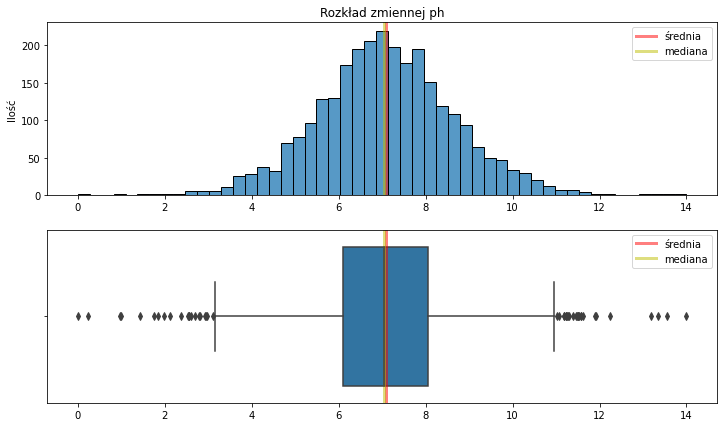

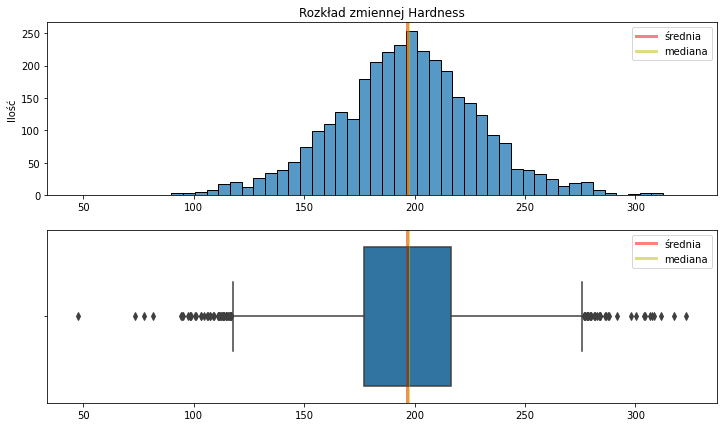

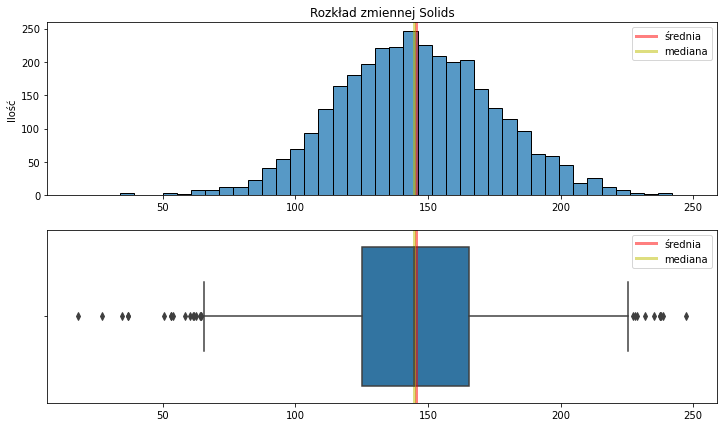

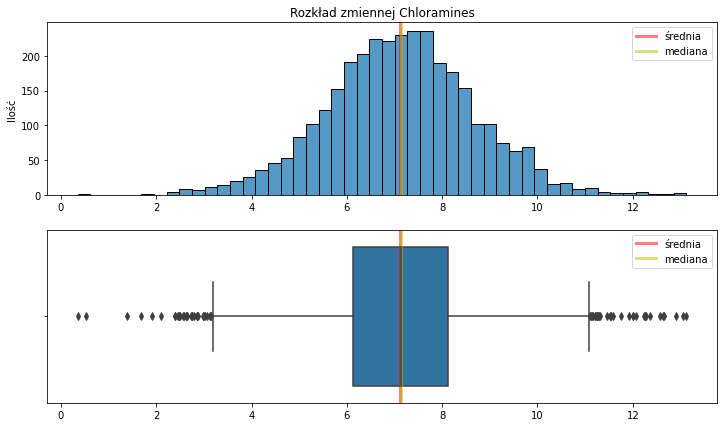

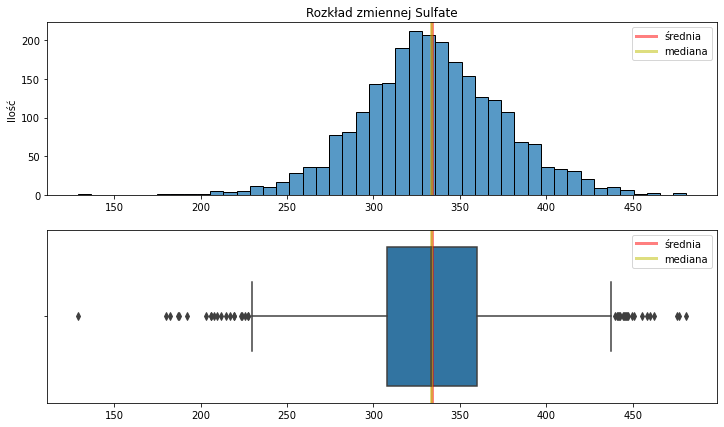

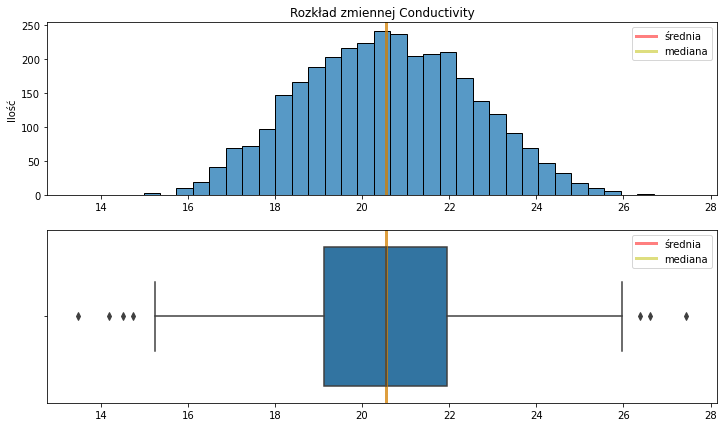

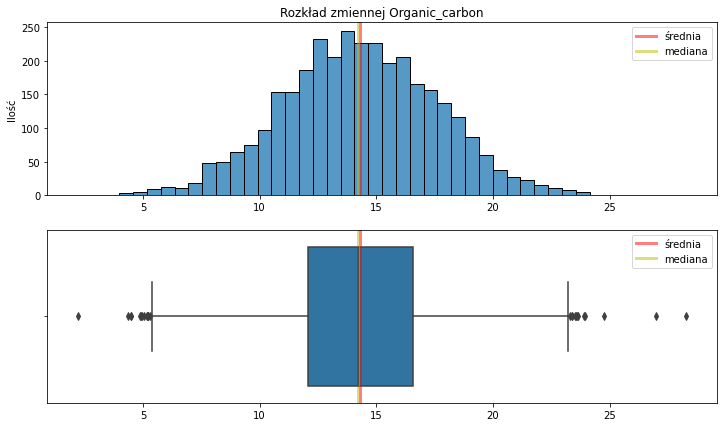

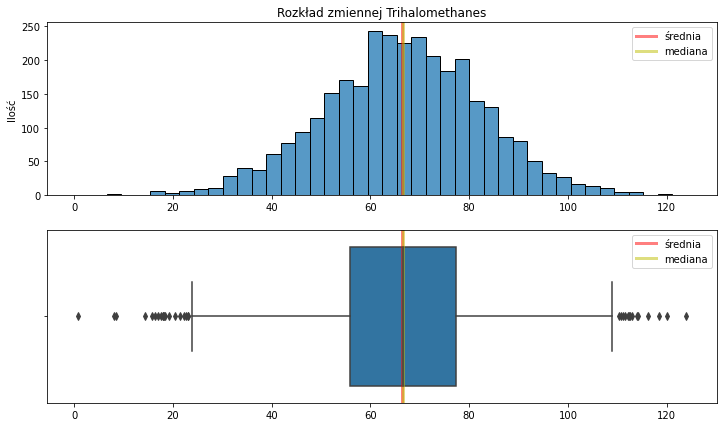

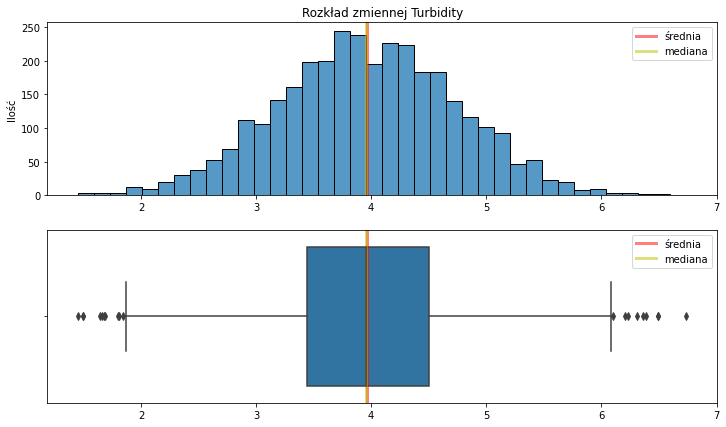

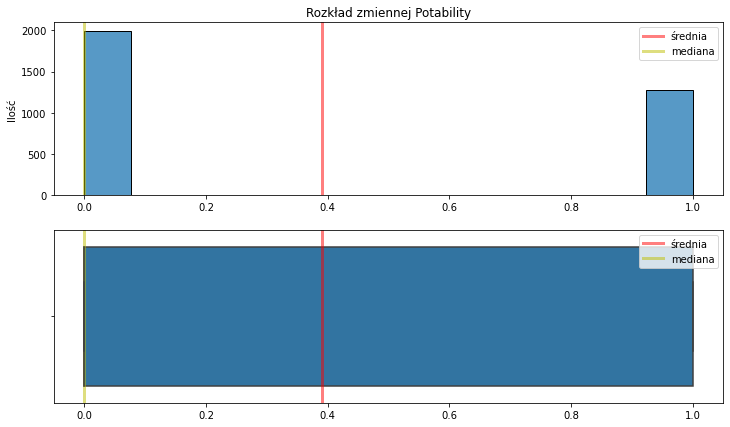

In [77]:
cols = df.columns
for col in cols:
    fig, axes = plt.subplots(2, 1,figsize=(12, 7))
    
    axes[0].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[0].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.histplot(df[col],ax=axes[0])
    
    axes[1].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[1].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.boxplot(x=df[col],ax=axes[1])

    axes[0].set_ylabel('Ilość')
    axes[0].set_xlabel('')
    axes[0].set_title("Rozkład zmiennej {}".format(col))
    axes[0].legend(["średnia", "mediana"])
    axes[1].legend(["średnia", "mediana"])
    axes[1].set_xlabel('')

After the square root transformation, the distribution of the variables is close to normal distribution, but we can see that there are outliers in the box plots of all the variables. The dataset is very small, which means that we should avoid removing outlier records and we should consider using non-parametric statistics, and algorithms that are not sensitive to outliers such as the tree methods.

In [78]:
cols = df.columns
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

ph = 0.025630447632210302
Hardness = -0.03934170477672744
Solids = -0.015157793420941923
Chloramines = -0.012098440124382135
Sulfate = -0.03594662160706183
Conductivity = 0.031893328896820373
Organic_carbon = 0.02553258209024246
Trihalomethanes = -0.08303067407901549
Turbidity = -0.007816642377392644
Potability = 0.4507837491078628


We can see that the skewness has definitely decreased due to the applied transformation.

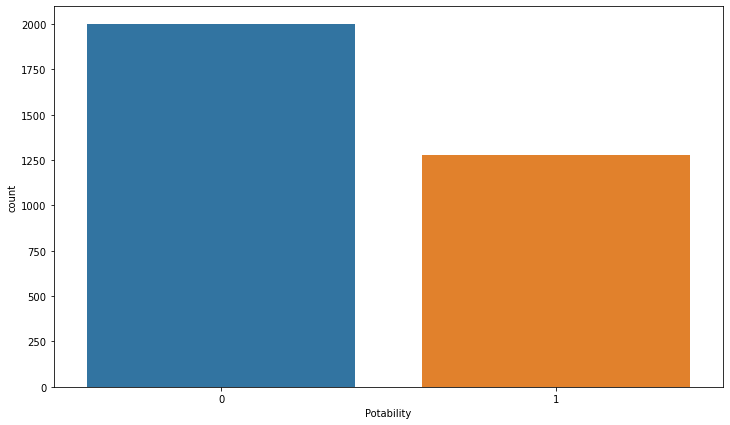

In [79]:
fig = plt.subplots(figsize=(12, 7))
ax.set_title("Ilość próbki Potability")
sns.countplot(x ='Potability', data = df);

Not very ballanced data set. Contains around 60 percent of not potable, and only around 40 percent potable.

### Feature engineering

In [80]:
def type_water(x):
    if x < 7:
        return 'Acidic'
    elif (x>=7) & (x<8):
        return 'Neutral'
    else:
        return 'Alkaline'
    
def water_hardness(x):
    
    if x<17.1:
        return 'Soft'
    elif (x>=17.1) & (x<60):
        return 'Sightly Hard'
    elif (x>=60) & (x<120):
        return 'Moderately Hard'
    elif (x>=120) & (x<180):
        return 'Hard'
    else:
        return 'Very Hard'

In [81]:
df['water_type'] = df['ph'].apply(lambda x : type_water(x))
df['water_hardness'] = df['Hardness'].apply(lambda x : water_hardness(x))

In [82]:
df = df[['ph', 'Hardness', 'Chloramines', 'Sulfate', 'Organic_carbon','Trihalomethanes', 'Turbidity','Solids','Conductivity','water_type', 'water_hardness','Potability']]

In [130]:
df = df.loc[df["water_hardness"] != "Sightly Hard" ]

In [131]:
#df = df.convert_dtypes()

## Prepare data

In [83]:
X  = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state,shuffle=True,stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2293, 11) (2293,)
(983, 11) (983,)


We divide the data into 2 parts: training, testing 

(2796, 11) (2796,)


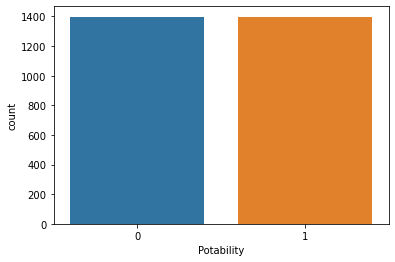

In [85]:
#Oversampling
over_sampler = RandomOverSampler(random_state=random_state)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
print(X_train.shape,y_train.shape)
full = X_train.copy()
full["Potability"] = y_train
sns.countplot(x ='Potability', data = full);

We used oversampling so that we balanced the set and have enough examples of both classes and the model can effectively learn the decision boundary between these classes.

In [86]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
nominal_columns = ['water_hardness']
ordinal_columns = ['water_type']
all_columns = X_train.columns

In [167]:
"""oversampling_pipeline = Pipeline([("over_sampling", SMOTE(random_state=42))])
selection_pipeline = Pipeline([("select_features",SelectPercentile(chi2, percentile=50))])

data_prepare_pipeline = ColumnTransformer([
    ("oversampling_preprocessor", oversampling_pipeline, all_columns) ,
    ("selection_preprocessor", selection_pipeline, all_columns)
])

data_prepare_pipeline = FeatureUnion([
    ('oversampling_preprocessor', oversampling_pipeline),
    ('selection_preprocessor', selection_pipeline)
])

data_prepare_pipeline.fit(X_train)"""

'oversampling_pipeline = Pipeline([("over_sampling", SMOTE(random_state=42))])\nselection_pipeline = Pipeline([("select_features",SelectPercentile(chi2, percentile=50))])\n\ndata_prepare_pipeline = ColumnTransformer([\n    ("oversampling_preprocessor", oversampling_pipeline, all_columns) ,\n    ("selection_preprocessor", selection_pipeline, all_columns)\n])\n\ndata_prepare_pipeline = FeatureUnion([\n    (\'oversampling_preprocessor\', oversampling_pipeline),\n    (\'selection_preprocessor\', selection_pipeline)\n])\n\ndata_prepare_pipeline.fit(X_train)'

In [87]:
numerical_pipeline = Pipeline([
    ('numerical_imputer', KNNImputer(missing_values=np.nan, n_neighbors=3)),
    ('numerical_transformer', StandardScaler()),
])

ordinal_pipeline   = Pipeline([
    ("ordinal_imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal_transformer", OrdinalEncoder())
])

nominal_pipeline  = Pipeline([
    ("nominal_imputer", SimpleImputer(strategy="most_frequent")),
    ("nominal_transformer", OneHotEncoder(sparse=True, handle_unknown="ignore"))
])

data_processing_pipeline = ColumnTransformer([
    ("nominal_preprocessor", nominal_pipeline, nominal_columns),
    ("ordinal_preprocessor", ordinal_pipeline, ordinal_columns),
    ("numerical_preprocessor", numerical_pipeline, numerical_columns)
])

data_processing_pipeline.fit_transform(X_train)

array([[ 1.        ,  0.        ,  0.        , ..., -0.73671513,
        -0.38067332, -0.23898863],
       [ 0.        ,  0.        ,  1.        , ...,  0.5147583 ,
         1.56502238,  1.92255638],
       [ 0.        ,  0.        ,  1.        , ...,  0.41998703,
        -1.30027967,  2.10402572],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.18351991,
         1.18222767,  1.01431642],
       [ 0.        ,  0.        ,  1.        , ..., -1.21649113,
        -1.80909101,  0.93462145],
       [ 1.        ,  0.        ,  0.        , ..., -0.86217782,
         1.22364172,  0.1289315 ]])

In [138]:
"""complete_pipeline = Pipeline([
    ("prepare", data_prepare_pipeline),
    ("preprocessor", data_processing_pipeline)
])

complete_pipeline.fit(X_train)"""

'complete_pipeline = Pipeline([\n    ("prepare", data_prepare_pipeline),\n    ("preprocessor", data_processing_pipeline)\n])\n\ncomplete_pipeline.fit(X_train)'

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
classifiers = [
        {
        'name': 'BaggingClassifier()',
        'class': BaggingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'random_state' : 42
           }
    },
    {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'min_samples_leaf':hp.uniformint('min_samples_leaf', 1, 5),
            'min_samples_split':hp.uniformint('min_samples_split', 2, 10),
            'bootstrap': hp.choice('bootstrap', [True,  False]),
            'max_features': hp.choice('max_features', ['auto', 'sqrt']),
            'random_state' : 42
           }
    },
     {
        'name': 'GradientBoostingClassifier()',
        'class': GradientBoostingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'random_state' : 42
           }
    },
    {
        'name': 'XGBClassifier()',
        'class': xgb.XGBClassifier(eval_metric = "mlogloss"),
        'max_evals': 100,
        'eval_metric': "mlogloss",
        'params' : {
            'learning_rate': hp.loguniform ('learning_rate', 0.01, 0.5),
            'max_depth': hp.choice('max_depth', np.arange(2, 11).tolist()),
            'min_child_weight': hp.choice('min_child_weight', np.arange(0, 101).tolist()),
            'gamma': hp.loguniform('gamma', 0.0, 2.0),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', 0.0, 2.0),
            'reg_lambda': hp.loguniform('reg_lambda', 0.0, 2.0),
            'random_state' : 42
        }
    },    
]

In [89]:
## TEST 
classifiers = [
 {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'min_samples_leaf':hp.uniformint('min_samples_leaf', 1, 5),
            'min_samples_split':hp.uniformint('min_samples_split', 2, 10),
            'bootstrap': hp.choice('bootstrap', [True,  False]),
            'max_features': hp.choice('max_features', ['auto', 'sqrt']),
            'random_state' : 42
           }
    },

]

In [90]:
import os
logger = log(path="./logs/", file="score.logs")

In [91]:
def objective(space):
    pipe_params = {}
    
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
        
    pipe.set_params(**pipe_params)
    
    score = cross_val_score(pipe, X_train, y_train, cv=10, scoring='roc_auc',n_jobs=-1).mean()
    
    return {'loss': 1- score, 'status': STATUS_OK, 'accuracy': score}

In [92]:
trials_df = []
 
for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")
    
    pipe = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', cl['class'])
    ])
    
    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]
    
    max_evals = cl['max_evals']
    
    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
     
    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))
    
    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'accuracy': trial['result']['accuracy'],
            'params': trial['misc']['vals']
            })



RandomForestClassifier
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO build_posterior_wrapper took 0.005370 seconds
INFO TPE using 0 trials


  1%|▍                                              | 1/100 [00:06<11:17,  6.84s/trial, best loss: 0.15582553956834533]

INFO build_posterior_wrapper took 0.011083 seconds
INFO TPE using 1/1 trials with best loss 0.155826


  2%|▉                                              | 2/100 [00:11<10:18,  6.31s/trial, best loss: 0.15582553956834533]

INFO build_posterior_wrapper took 0.005416 seconds
INFO TPE using 2/2 trials with best loss 0.155826


  3%|█▍                                             | 3/100 [00:20<11:13,  6.95s/trial, best loss: 0.15582553956834533]

INFO build_posterior_wrapper took 0.144137 seconds
INFO TPE using 3/3 trials with best loss 0.155826


  4%|█▉                                             | 4/100 [00:22<09:01,  5.64s/trial, best loss: 0.15582553956834533]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 4/4 trials with best loss 0.155826


  5%|██▎                                            | 5/100 [00:24<07:06,  4.49s/trial, best loss: 0.15582553956834533]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 5/5 trials with best loss 0.155826


  6%|███                                               | 6/100 [00:29<07:07,  4.55s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.002992 seconds
INFO TPE using 6/6 trials with best loss 0.138288


  7%|███▌                                              | 7/100 [00:33<06:41,  4.32s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 7/7 trials with best loss 0.138288


  8%|████                                              | 8/100 [00:35<05:37,  3.66s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 8/8 trials with best loss 0.138288


  9%|████▌                                             | 9/100 [00:38<05:06,  3.37s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.002892 seconds
INFO TPE using 9/9 trials with best loss 0.138288


 10%|████▉                                            | 10/100 [00:42<05:34,  3.72s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.002033 seconds
INFO TPE using 10/10 trials with best loss 0.138288


 11%|█████▍                                           | 11/100 [00:45<05:02,  3.40s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.002029 seconds
INFO TPE using 11/11 trials with best loss 0.138288


 12%|█████▉                                           | 12/100 [00:51<06:27,  4.41s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.008611 seconds
INFO TPE using 12/12 trials with best loss 0.138288


 13%|██████▎                                          | 13/100 [00:55<06:09,  4.24s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 13/13 trials with best loss 0.138288


 14%|██████▊                                          | 14/100 [00:59<05:52,  4.10s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 14/14 trials with best loss 0.138288


 15%|███████▎                                         | 15/100 [01:01<04:42,  3.32s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.002045 seconds
INFO TPE using 15/15 trials with best loss 0.138288


 16%|███████▊                                         | 16/100 [01:04<04:30,  3.22s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 16/16 trials with best loss 0.138288


 17%|████████▎                                        | 17/100 [01:05<03:48,  2.76s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 17/17 trials with best loss 0.138288


 18%|████████▊                                        | 18/100 [01:08<03:37,  2.65s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.007561 seconds
INFO TPE using 18/18 trials with best loss 0.138288


 19%|█████████▎                                       | 19/100 [01:10<03:32,  2.62s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 19/19 trials with best loss 0.138288


 20%|█████████▊                                       | 20/100 [01:14<04:09,  3.12s/trial, best loss: 0.13828802672148]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 20/20 trials with best loss 0.138288


 21%|█████████▋                                    | 21/100 [01:20<04:56,  3.75s/trial, best loss: 0.13122522390251068]

INFO build_posterior_wrapper took 0.006222 seconds
INFO TPE using 21/21 trials with best loss 0.131225


 22%|██████████                                    | 22/100 [01:25<05:33,  4.28s/trial, best loss: 0.13040364850976371]

INFO build_posterior_wrapper took 0.002028 seconds
INFO TPE using 22/22 trials with best loss 0.130404


 23%|██████████▌                                   | 23/100 [01:31<06:05,  4.75s/trial, best loss: 0.13040364850976371]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 23/23 trials with best loss 0.130404


 24%|███████████                                   | 24/100 [01:37<06:38,  5.24s/trial, best loss: 0.13040364850976371]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 24/24 trials with best loss 0.130404


 25%|███████████▊                                   | 25/100 [01:43<06:48,  5.45s/trial, best loss: 0.1301145573337248]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 25/25 trials with best loss 0.130115


 26%|███████████▉                                  | 26/100 [01:50<06:59,  5.67s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 26/26 trials with best loss 0.129222


 27%|████████████▍                                 | 27/100 [01:56<07:04,  5.82s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 27/27 trials with best loss 0.129222


 28%|████████████▉                                 | 28/100 [02:02<07:05,  5.92s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 28/28 trials with best loss 0.129222


 29%|█████████████▎                                | 29/100 [02:07<06:36,  5.58s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 29/29 trials with best loss 0.129222


 30%|█████████████▊                                | 30/100 [02:12<06:21,  5.45s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 30/30 trials with best loss 0.129222


 31%|██████████████▎                               | 31/100 [02:20<07:02,  6.13s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.004934 seconds
INFO TPE using 31/31 trials with best loss 0.129222


 32%|██████████████▋                               | 32/100 [02:26<06:54,  6.09s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.004162 seconds
INFO TPE using 32/32 trials with best loss 0.129222


 33%|███████████████▏                              | 33/100 [02:28<05:43,  5.12s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 33/33 trials with best loss 0.129222


 34%|███████████████▋                              | 34/100 [02:33<05:24,  4.91s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 34/34 trials with best loss 0.129222


 35%|████████████████                              | 35/100 [02:38<05:17,  4.89s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.009480 seconds
INFO TPE using 35/35 trials with best loss 0.129222


 36%|████████████████▌                             | 36/100 [02:42<05:00,  4.69s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 36/36 trials with best loss 0.129222


 37%|█████████████████                             | 37/100 [02:51<06:24,  6.10s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002993 seconds
INFO TPE using 37/37 trials with best loss 0.129222


 38%|█████████████████▍                            | 38/100 [02:56<05:59,  5.80s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 38/38 trials with best loss 0.129222


 39%|█████████████████▉                            | 39/100 [03:02<05:55,  5.83s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002028 seconds
INFO TPE using 39/39 trials with best loss 0.129222


 40%|██████████████████▍                           | 40/100 [03:07<05:22,  5.38s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001964 seconds
INFO TPE using 40/40 trials with best loss 0.129222


 41%|██████████████████▊                           | 41/100 [03:13<05:27,  5.54s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 41/41 trials with best loss 0.129222


 42%|███████████████████▎                          | 42/100 [03:17<05:08,  5.31s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 42/42 trials with best loss 0.129222


 43%|███████████████████▊                          | 43/100 [03:21<04:27,  4.70s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 43/43 trials with best loss 0.129222


 44%|████████████████████▏                         | 44/100 [03:24<03:58,  4.25s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 44/44 trials with best loss 0.129222


 45%|████████████████████▋                         | 45/100 [03:30<04:22,  4.77s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 45/45 trials with best loss 0.129222


 46%|█████████████████████▏                        | 46/100 [03:34<04:01,  4.47s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002046 seconds
INFO TPE using 46/46 trials with best loss 0.129222


 47%|█████████████████████▌                        | 47/100 [03:42<04:53,  5.55s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.007487 seconds
INFO TPE using 47/47 trials with best loss 0.129222


 48%|██████████████████████                        | 48/100 [03:45<04:12,  4.85s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 48/48 trials with best loss 0.129222


 49%|██████████████████████▌                       | 49/100 [03:49<03:50,  4.51s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 49/49 trials with best loss 0.129222


 50%|███████████████████████                       | 50/100 [03:55<04:13,  5.08s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002993 seconds
INFO TPE using 50/50 trials with best loss 0.129222


 51%|███████████████████████▍                      | 51/100 [03:58<03:32,  4.34s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 51/51 trials with best loss 0.129222


 52%|███████████████████████▉                      | 52/100 [04:01<03:14,  4.06s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 52/52 trials with best loss 0.129222


 53%|████████████████████████▍                     | 53/100 [04:05<03:14,  4.14s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001962 seconds
INFO TPE using 53/53 trials with best loss 0.129222


 54%|████████████████████████▊                     | 54/100 [04:09<03:04,  4.01s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000993 seconds
INFO TPE using 54/54 trials with best loss 0.129222


 55%|█████████████████████████▎                    | 55/100 [04:12<02:45,  3.69s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 55/55 trials with best loss 0.129222


 56%|█████████████████████████▊                    | 56/100 [04:19<03:22,  4.61s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 56/56 trials with best loss 0.129222


 57%|██████████████████████████▏                   | 57/100 [04:24<03:30,  4.89s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 57/57 trials with best loss 0.129222


 58%|██████████████████████████▋                   | 58/100 [04:32<03:56,  5.64s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 58/58 trials with best loss 0.129222


 59%|███████████████████████████▏                  | 59/100 [04:37<03:41,  5.41s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002991 seconds
INFO TPE using 59/59 trials with best loss 0.129222


 60%|███████████████████████████▌                  | 60/100 [04:43<03:44,  5.61s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002027 seconds
INFO TPE using 60/60 trials with best loss 0.129222


 61%|████████████████████████████                  | 61/100 [04:46<03:08,  4.83s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.007332 seconds
INFO TPE using 61/61 trials with best loss 0.129222


 62%|████████████████████████████▌                 | 62/100 [04:53<03:31,  5.58s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 62/62 trials with best loss 0.129222


 63%|████████████████████████████▉                 | 63/100 [04:58<03:25,  5.56s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 63/63 trials with best loss 0.129222


 64%|█████████████████████████████▍                | 64/100 [05:03<03:10,  5.30s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 64/64 trials with best loss 0.129222


 65%|█████████████████████████████▉                | 65/100 [05:05<02:33,  4.40s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001997 seconds
INFO TPE using 65/65 trials with best loss 0.129222


 66%|██████████████████████████████▎               | 66/100 [05:11<02:44,  4.83s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 66/66 trials with best loss 0.129222


 67%|██████████████████████████████▊               | 67/100 [05:17<02:51,  5.19s/trial, best loss: 0.12922232418147106]

INFO build_posterior_wrapper took 0.002027 seconds
INFO TPE using 67/67 trials with best loss 0.129222


 68%|███████████████████████████████▎              | 68/100 [05:24<03:03,  5.75s/trial, best loss: 0.12910189399500815]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 68/68 trials with best loss 0.129102


 69%|███████████████████████████████▋              | 69/100 [05:31<03:03,  5.92s/trial, best loss: 0.12910189399500815]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 69/69 trials with best loss 0.129102


 70%|████████████████████████████████▏             | 70/100 [05:37<03:03,  6.10s/trial, best loss: 0.12910189399500815]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 70/70 trials with best loss 0.129102


 71%|████████████████████████████████▋             | 71/100 [05:44<03:02,  6.28s/trial, best loss: 0.12910189399500815]

INFO build_posterior_wrapper took 0.001963 seconds
INFO TPE using 71/71 trials with best loss 0.129102


 72%|█████████████████████████████████             | 72/100 [05:50<02:57,  6.34s/trial, best loss: 0.12910189399500815]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 72/72 trials with best loss 0.129102


 73%|█████████████████████████████████▌            | 73/100 [05:56<02:48,  6.24s/trial, best loss: 0.12910189399500815]

INFO build_posterior_wrapper took 0.002029 seconds
INFO TPE using 73/73 trials with best loss 0.129102


 74%|██████████████████████████████████▊            | 74/100 [06:02<02:38,  6.09s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 74/74 trials with best loss 0.129082


 75%|███████████████████████████████████▎           | 75/100 [06:08<02:29,  5.98s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 75/75 trials with best loss 0.129082


 76%|███████████████████████████████████▋           | 76/100 [06:13<02:20,  5.85s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 76/76 trials with best loss 0.129082


 77%|████████████████████████████████████▏          | 77/100 [06:18<02:04,  5.43s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 77/77 trials with best loss 0.129082


 78%|████████████████████████████████████▋          | 78/100 [06:22<01:54,  5.19s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001976 seconds
INFO TPE using 78/78 trials with best loss 0.129082


 79%|█████████████████████████████████████▏         | 79/100 [06:30<02:02,  5.81s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001962 seconds
INFO TPE using 79/79 trials with best loss 0.129082


 80%|█████████████████████████████████████▌         | 80/100 [06:34<01:46,  5.33s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 80/80 trials with best loss 0.129082


 81%|██████████████████████████████████████         | 81/100 [06:39<01:37,  5.11s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 81/81 trials with best loss 0.129082


 82%|██████████████████████████████████████▌        | 82/100 [06:44<01:34,  5.22s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 82/82 trials with best loss 0.129082


 83%|███████████████████████████████████████        | 83/100 [06:50<01:34,  5.54s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 83/83 trials with best loss 0.129082


 84%|███████████████████████████████████████▍       | 84/100 [06:55<01:25,  5.36s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 84/84 trials with best loss 0.129082


 85%|███████████████████████████████████████▉       | 85/100 [07:01<01:20,  5.37s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001997 seconds
INFO TPE using 85/85 trials with best loss 0.129082


 86%|████████████████████████████████████████▍      | 86/100 [07:06<01:15,  5.41s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 86/86 trials with best loss 0.129082


 87%|████████████████████████████████████████▉      | 87/100 [07:12<01:13,  5.68s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.002026 seconds
INFO TPE using 87/87 trials with best loss 0.129082


 88%|█████████████████████████████████████████▎     | 88/100 [07:19<01:11,  5.96s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001961 seconds
INFO TPE using 88/88 trials with best loss 0.129082


 89%|█████████████████████████████████████████▊     | 89/100 [07:22<00:55,  5.06s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001957 seconds
INFO TPE using 89/89 trials with best loss 0.129082


 90%|██████████████████████████████████████████▎    | 90/100 [07:28<00:53,  5.31s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 90/90 trials with best loss 0.129082


 91%|██████████████████████████████████████████▊    | 91/100 [07:32<00:44,  4.92s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 91/91 trials with best loss 0.129082


 92%|███████████████████████████████████████████▏   | 92/100 [07:39<00:43,  5.43s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.002028 seconds
INFO TPE using 92/92 trials with best loss 0.129082


 93%|███████████████████████████████████████████▋   | 93/100 [07:44<00:37,  5.29s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.007812 seconds
INFO TPE using 93/93 trials with best loss 0.129082


 94%|████████████████████████████████████████████▏  | 94/100 [07:48<00:30,  5.07s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 94/94 trials with best loss 0.129082


 95%|████████████████████████████████████████████▋  | 95/100 [07:54<00:26,  5.40s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 95/95 trials with best loss 0.129082


 96%|█████████████████████████████████████████████  | 96/100 [08:00<00:22,  5.52s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 96/96 trials with best loss 0.129082


 97%|█████████████████████████████████████████████▌ | 97/100 [08:04<00:15,  5.10s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.001963 seconds
INFO TPE using 97/97 trials with best loss 0.129082


 98%|██████████████████████████████████████████████ | 98/100 [08:08<00:09,  4.58s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 98/98 trials with best loss 0.129082


 99%|██████████████████████████████████████████████▌| 99/100 [08:13<00:04,  4.84s/trial, best loss: 0.1290817794743797]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 99/99 trials with best loss 0.129082


100%|██████████████████████████████████████████████| 100/100 [08:19<00:00,  4.99s/trial, best loss: 0.1290817794743797]

The best params:
Parameter                      Selected
bootstrap                      True
max_depth                      20
max_features                   auto
min_samples_leaf               1
min_samples_split              3
n_estimators                   391
random_state                   42


In [93]:
trials_df = pd.DataFrame(trials_df)
trials_df.sort_values('accuracy', ascending=False)

,classifier,loss,accuracy,params
73,RandomForestClassifier,0.129082,0.870918,"{'bootstrap': [0], 'max_depth': [20.0], 'max_f..."
67,RandomForestClassifier,0.129102,0.870898,"{'bootstrap': [0], 'max_depth': [20.0], 'max_f..."
74,RandomForestClassifier,0.129178,0.870822,"{'bootstrap': [0], 'max_depth': [20.0], 'max_f..."
25,RandomForestClassifier,0.129222,0.870778,"{'bootstrap': [0], 'max_depth': [19.0], 'max_f..."
26,RandomForestClassifier,0.129235,0.870765,"{'bootstrap': [0], 'max_depth': [20.0], 'max_f..."
...,...,...,...,...
17,RandomForestClassifier,0.363692,0.636308,"{'bootstrap': [1], 'max_depth': [4.0], 'max_fe..."
97,RandomForestClassifier,0.366344,0.633656,"{'bootstrap': [0], 'max_depth': [3.0], 'max_fe..."
54,RandomForestClassifier,0.366755,0.633245,"{'bootstrap': [0], 'max_depth': [3.0], 'max_fe..."
32,RandomForestClassifier,0.399218,0.600782,"{'bootstrap': [0], 'max_depth': [2.0], 'max_fe..."


In [94]:
top_models = trials_df.sort_values('accuracy', ascending=False)
logger.info("-------------------------------")
logger.info("TOP 10 MODELS WITH Imputation: Mean")
logger.info(top_models.head(10))

INFO -------------------------------
INFO TOP 10 MODELS WITH Imputation: Mean
INFO                 classifier      loss  accuracy  \
73  RandomForestClassifier  0.129082  0.870918   
67  RandomForestClassifier  0.129102  0.870898   
74  RandomForestClassifier  0.129178  0.870822   
25  RandomForestClassifier  0.129222  0.870778   
26  RandomForestClassifier  0.129235  0.870765   
68  RandomForestClassifier  0.129235  0.870765   
81  RandomForestClassifier  0.129525  0.870475   
82  RandomForestClassifier  0.129551  0.870449   
40  RandomForestClassifier  0.129951  0.870049   
55  RandomForestClassifier  0.130045  0.869955   

                                               params  
73  {'bootstrap': [0], 'max_depth': [20.0], 'max_f...  
67  {'bootstrap': [0], 'max_depth': [20.0], 'max_f...  
74  {'bootstrap': [0], 'max_depth': [20.0], 'max_f...  
25  {'bootstrap': [0], 'max_depth': [19.0], 'max_f...  
26  {'bootstrap': [0], 'max_depth': [20.0], 'max_f...  
68  {'bootstrap': [0], 'max_de

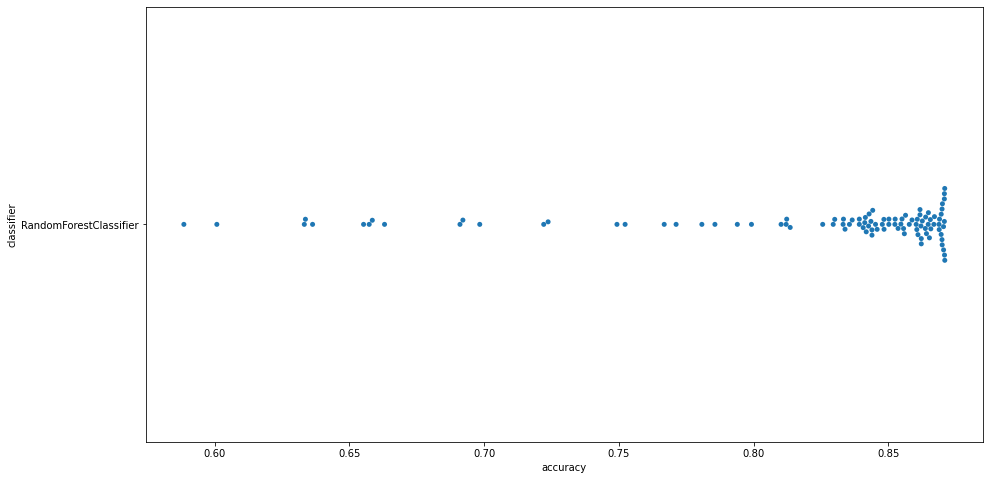

In [95]:
plt.figure(figsize=(15,8))
sns.swarmplot(data=trials_df, y='classifier', x='accuracy');

In [100]:
print("The best model " + top_models.iloc[0][0])
parameters=top_models.iloc[0][3]

keys = []
values = []
for key, value in parameters.items():
    keys.append(key)
    values.append(int(value[0]))
params = dict(zip(keys, values))

The best model RandomForestClassifier


In [98]:
params

{'bootstrap': 0,
 'max_depth': 20,
 'max_features': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 391}

In [102]:
pipe_finall = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', RandomForestClassifier(bootstrap=True,max_depth=20,min_samples_leaf=1,min_samples_split=3,n_estimators=391))
    ])


pipe_finall.fit(X_train, y_train)

Pipeline(steps=[('data_processing_pipeline',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('nominal_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['water_hardness']),
                                                 ('ordinal_preprocessor',
                                                  Pipeline(steps=[('ordinal_imputer',
                                                                   SimpleImputer(strategy='most_f...
                                                 ('numerical_preprocessor',
                                                  Pipeline(steps=[('numerical_

In [157]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in pipe_finall.steps[1][1].estimators_ 
], axis=0)

In [160]:
feature_importances

array([0.13864175, 0.11494992, 0.1134548 , 0.13413441, 0.09970037,
       0.09570998, 0.09532681, 0.11026516, 0.09781679])

In [43]:
df.columns[0:9]

Index(['ph', 'Hardness', 'Chloramines', 'Sulfate', 'Organic_carbon',
       'Trihalomethanes', 'Turbidity', 'Solids', 'Conductivity'],
      dtype='object')

In [152]:
pipe_finall.steps[1][1].estimators_ 

BaggingClassifier(n_estimators=499)

In [103]:
data_processing_pipeline.transform(X_test)
y_pred = pipe_finall.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73       600
           1       0.55      0.40      0.47       383

    accuracy                           0.64       983
   macro avg       0.61      0.60      0.60       983
weighted avg       0.63      0.64      0.63       983



In [105]:
print(accuracy_score(y_test,y_pred))

0.6398779247202442


AxesSubplot(0.125,0.125;0.62x0.755)


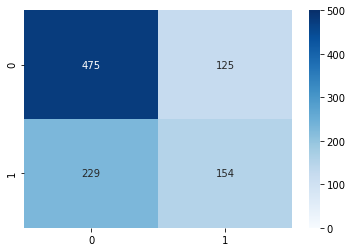

In [106]:

print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=500,annot=True,cmap='Blues',fmt='g'));